# Import librairies & data

In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random

In [3]:
from asteroid_mining.data import Data

In [4]:
df_neo = Data().get_neo_data()

/home/corentin/.pyenv/versions/3.8.6/envs/asteroid_mining/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (5,17,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
df_acc = Data().get_acc_data()

# Estimate resources per asteroid

## Get % of resources with the spec

### Get the spec of the asteroid

In [9]:
df_acc.shape

(659, 86)

In [10]:
df_acc['spec_B'].head()

0      NaN
1    S(IV)
2      NaN
3       Sq
4        B
Name: spec_B, dtype: object

In [11]:
def clean_spec(x):
    x = str(x).replace(':', '')
    x = str(x).replace('(IV)', '')
    return x

In [12]:
# Clean a bit spec_B column on df_neo & df_acc to have a clearer view
df_neo['spec_B_clean'] = df_neo['spec_B'].apply(clean_spec)
df_acc['spec_B_clean'] = df_acc['spec_B'].apply(clean_spec)

In [13]:
# Inspect spec information on df_acc
spec_counts_acc = df_acc[['id', 'spec_B_clean']].groupby(['spec_B_clean']).count().reset_index()
spec_counts_acc

,spec_B_clean,id
0,B,1
1,Cg,1
2,S,4
3,Sq,2
4,X,1
5,nan,650


In [14]:
# Counting number of asteroids that have spec info
spec_counts_acc['id'].sum()

659

We only have information on spec for 9 asteroids out of the 659 we have in the accessible dataframe. Let's have a look at df_neo:

In [15]:
spec_counts_neo = df_neo[['id', 'spec_B_clean']].groupby(['spec_B_clean']).count().reset_index()
spec_counts_neo

,spec_B_clean,id
0,A,1
1,B,5
2,C,13
3,Cb,3
4,Cg,1
5,Ch,1
6,D,4
7,K,7
8,L,6
9,Ld,2


Even if we have a lot of missing info, there is data to exploit to estimate the spec repartition of df_acc

In [16]:
# Delete nan from spec_counts_neo
index_to_del = spec_counts_neo[ spec_counts_neo['spec_B_clean'] == 'nan'].index

In [17]:
index_to_del

Int64Index([26], dtype='int64')

In [18]:
spec_counts_neo.drop(index_to_del , inplace=True)

In [19]:
sum_spec_neo = spec_counts_neo['id'].sum()

In [20]:
# Get percentage of each spec 
spec_counts_neo['per_spec'] = spec_counts_neo['id'].apply(lambda x: x / sum_spec_neo)

In [21]:
spec_counts_neo['cum_perc_spec'] = spec_counts_neo['per_spec'].cumsum()

In [22]:
spec_counts_neo

,spec_B_clean,id,per_spec,cum_perc_spec
0,A,1,0.003226,0.003226
1,B,5,0.016129,0.019355
2,C,13,0.041935,0.061290
3,Cb,3,0.009677,0.070968
4,Cg,1,0.003226,0.074194
5,Ch,1,0.003226,0.077419
6,D,4,0.012903,0.090323
7,K,7,0.022581,0.112903
8,L,6,0.019355,0.132258
9,Ld,2,0.006452,0.138710


In [23]:
from random import uniform

In [24]:
a = uniform(0,1)

for i in range(spec_counts_neo.shape[0]):
    if a > spec_counts_neo.loc[i, 'cum_perc_spec']:
        continue
    else:
        new_spec = spec_counts_neo.loc[i, 'spec_B_clean']
        break
        
print(f'{a}: {new_spec} spec')

0.9720987921871594: Xe spec


In [25]:
df_acc.loc[300, 'spec_B_clean']

'nan'

In [27]:
def new_spec_acc(x):
    
    # Check if spec is nan
    if x == 'nan':
    
        a = uniform(0,1)

        for i in range(spec_counts_neo.shape[0]):
            if a > spec_counts_neo.loc[i, 'cum_perc_spec']:
                continue
            else:
                new_spec = spec_counts_neo.loc[i, 'spec_B_clean']
                break
        return new_spec
    
    else:
        return x

In [28]:
df_acc['new_spec'] = df_acc['spec_B_clean'].apply(new_spec_acc)

In [29]:
# Check that each asteroid of df_acc has an estimated spec
df_acc['new_spec']

0       D
1       S
2       X
3      Sq
4       B
       ..
654     C
655     C
656    Sq
657    Xk
658     V
Name: new_spec, Length: 659, dtype: object

### Estimate the % of resources for each asteroid according to its spec

In [30]:
acc_resources = df_acc[['id', 'new_spec']]
acc_resources.head()

,id,new_spec
0,a0003361,D
1,a0025143,S
2,a0089136,X
3,a0099942,Sq
4,a0101955,B


In [36]:
# Check that all specs in acc_resources are in the dictionary keys
missing_keys = []
for i in list(acc_resources['new_spec'].unique()):
    if i not in list(spec_per_resources.keys()):
        i.append(missing_keys)
missing_keys

[]

In [37]:
'id' in acc_resources.columns

True

In [38]:
for key in spec_per_resources:
    for key1 in spec_per_resources[key]:
        if key1 not in acc_resources.columns:
            acc_resources[key1] = ''

<ipython-input-38-52f5eba439a5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_resources[key1] = ''


In [39]:
resources_list = list(acc_resources.columns)
resources_list.remove('id')
resources_list.remove('new_spec')

In [40]:
resources_list

['hydrogen',
 'nitrogen',
 'ammonia',
 'iron',
 'water',
 'nickel',
 'cobalt',
 'magnesium silicate',
 'iron silicate',
 'aluminum',
 'nickel-iron',
 'platinum']

In [41]:
for col in resources_list:
    for i, row in acc_resources.iterrows():
        if col in spec_per_resources[row['new_spec']]:
            acc_resources.at[i,col] = spec_per_resources[row['new_spec']][col]

In [42]:
acc_resources

,id,new_spec,hydrogen,nitrogen,ammonia,iron,water,nickel,cobalt,magnesium silicate,iron silicate,aluminum,nickel-iron,platinum
0,a0003361,D,,,,,0.000023,,,,,,,
1,a0025143,S,,,,,,,,0.0,0,,,
2,a0089136,X,,,,88,,10,0.5,,,,,
3,a0099942,Sq,,,,,,,,0.0,0,,,
4,a0101955,B,0.235,0.001,0.001,10,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,bK18T00A,C,0.235,0.001,0.001,0.166,0.2,0.014,0.002,,,,,
655,bK18T00R,C,0.235,0.001,0.001,0.166,0.2,0.014,0.002,,,,,
656,bK18T01Z,Sq,,,,,,,,0.0,0,,,
657,bK18T06D,Xk,,,,88,,10,0.5,,,,,


In [43]:
'hydrogen' in spec_per_resources['A']

False

In [35]:
spec_per_resources = {
  '?': {},
  'A': {},
  'B': {
    'hydrogen': 0.235,
    'nitrogen': 0.001,
    'ammonia': 0.001,
    'iron': 10,
  },
  'C': {
    # from Keck report at http://www.kiss.caltech.edu/study/asteroid/asteroid_final_report.pdf
    'water': .2,
    'iron': .166,
    'nickel': .014,
    'cobalt': .002,

    # volatiles
    'hydrogen': 0.235,
    'nitrogen': 0.001,
    'ammonia': 0.001,
  },
  'Ch': {
    # from Keck report at http://www.kiss.caltech.edu/study/asteroid/asteroid_final_report.pdf
    'water': .2,
    'iron': .166,
    'nickel': .014,
    'cobalt': .002,

    # volatiles
    'hydrogen': 0.235,
    'nitrogen': 0.001,
    'ammonia': 0.001,
  },
  'Cg': {
    # from Keck report at http://www.kiss.caltech.edu/study/asteroid/asteroid_final_report.pdf
    'water': .2,
    'iron': .166,
    'nickel': .014,
    'cobalt': .002,

    # volatiles
    'hydrogen': 0.235,
    'nitrogen': 0.001,
    'ammonia': 0.001,
  },
  'Cgh': {
    # from Keck report at http://www.kiss.caltech.edu/study/asteroid/asteroid_final_report.pdf
    'water': .2,
    'iron': .166,
    'nickel': .014,
    'cobalt': .002,

    # volatiles
    'hydrogen': 0.235,
    'nitrogen': 0.001,
    'ammonia': 0.001,
  },
  'C': {
    # from Keck report at http://www.kiss.caltech.edu/study/asteroid/asteroid_final_report.pdf
    'water': .2,
    'iron': .166,
    'nickel': .014,
    'cobalt': .002,

    # volatiles
    'hydrogen': 0.235,
    'nitrogen': 0.001,
    'ammonia': 0.001,
  },
  'Cb': {   # transition object between C and B
    # from Keck report at http://www.kiss.caltech.edu/study/asteroid/asteroid_final_report.pdf
    'water': .1,
    'iron': .083,
    'nickel': .007,
    'cobalt': .001,

    # volatiles
    'hydrogen': 0.235,
    'nitrogen': 0.001,
    'ammonia': 0.001,
  },
  'D': {
    'water': 0.000023,
  },
  'E': {

  },
  'K': {  # cross between S and C
    # from Keck report at http://www.kiss.caltech.edu/study/asteroid/asteroid_final_report.pdf
    'water': .1,
    'iron': .083,
    'nickel': .007,
    'cobalt': .001,

    # volatiles
    'hydrogen': 0.235,
    'nitrogen': 0.001,
    'ammonia': 0.001,
  },
  'L': {
    'magnesium silicate': 1e-30,
    'iron silicate': 0,
    'aluminum': 7
  },
  'Ld': {  # copied from S
    'magnesium silicate': 1e-30,
    'iron silicate': 0,
  },
  'M': {
    'iron': 88,
    'nickel': 10,
    'cobalt': 0.5,
  },
  'O': {
    'nickel-iron': 2.965,
    'platinum': 1.25,
  },
  'P': {  # correspond to CI, CM carbonaceous chondrites
    'water': 12.5,
  },
  'R': {
    'magnesium silicate': 1e-30,
    'iron silicate': 0,
  },
  'S': {
    'magnesium silicate': 1e-30,
    'iron silicate': 0,
  },
  # Sa, Sq, Sr, Sk, and Sl all transition objects (assume half/half)
  'Sa': {
    'magnesium silicate': 5e-31,
    'iron silicate': 0,
  },
  'Sq': {
    'magnesium silicate': 1e-30,
    'iron silicate': 0,
  },
  'Sr': {
    'magnesium silicate': 1e-30,
    'iron silicate': 0,
  },
  'Sk': {
    'magnesium silicate': 1e-30,
    'iron silicate': 0,
  },
  'Sl': {
    'magnesium silicate': 1e-30,
    'iron silicate': 0,
  },
  'S(IV)': {
    'magnesium silicate': 1e-30,
    'iron silicate': 0,
  },
  'Q': {
    'nickel-iron': 13.315,
  },
  'R': {
    'magnesium silicate': 1e-30,
    'iron silicate': 0,
  },
  'T': {
    'iron': 6,
  },
  'U': {

  },
  'V': {
    'magnesium silicate': 1e-30,
    'iron silicate': 0,
  },

  # TODO use density to decide what kind of X the object is?

  'X': {  # TODO these vals only apply to M-type within X
    'iron': 88,
    'nickel': 10,
    'cobalt': 0.5,
  },
  'Xe': {  # TODO these vals only apply to M-type within X
    'iron': 88,
    'nickel': 10,
    'cobalt': 0.5,
  },
  'Xc': {  # TODO these vals only apply to M-type within X
    'iron': 88,
    'nickel': 10,
    'cobalt': 0.5,
    'platinum': 0.005,
  },
  'Xk': {  # TODO these vals only apply to M-type within X
    'iron': 88,
    'nickel': 10,
    'cobalt': 0.5,
  },
  'comet': {
      # no estimates for now, because assumed mass, etc. would be off
  },
}

## Get the mass of each asteroid

### Get the diameter

In [47]:
df_acc[~df_acc['Estimated Diameter (m)'].isnull()].shape

(659, 88)

In [59]:
def clean_diameter_acc(x):
    items = x.split('-')
    
    items_new = []
    for i in items:
        items_new.append(int(i.strip()))
    
    return sum(items_new) / len(items_new) / 1000

In [60]:
df_acc['diameter_clean'] = df_acc['Estimated Diameter (m)'].apply(clean_diameter_acc)

In [61]:
df_acc[['Estimated Diameter (m)', 'diameter_clean']]

,Estimated Diameter (m),diameter_clean
0,272 - 1216,0.7440
1,282 - 1262,0.7720
2,159 - 709,0.4340
3,200 - 893,0.5465
4,159 - 713,0.4360
...,...,...
654,19 - 85,0.0520
655,14 - 62,0.0380
656,17 - 78,0.0475
657,18 - 81,0.0495


### Get the volume based on diameter

In [62]:
df_acc['est_volume'] = 4/3 * math.pi * ((df_acc['diameter_clean'] / 2) ** 3)

In [76]:
df_acc[df_acc['est_volume'] < 0]

,Unnamed: 0,id,spkid,full_name,pdes,name,prefix,neo,pha,H,...,"Min. Duration [delta-V, dur.] (km/s), (d)",Viable Trajectories,Next Optical Opportunity (yyyy-mm [Vp]),Next Goldstone Radar Opportunity (yyyy-mm [SNR]),spec_B_clean,new_spec,diameter_clean,est_volume,est_density,est_mass


### Get the density

In [55]:
TYPE_DENSITY_MAP = {
  'C': 1.38,
  'D': 1.38,
  'P': 1.38,
  'T': 1.38,
  'B': 1.38,
  'G': 1.38,
  'F': 1.38,
  'S': 2.71,
  'K': 2.71,
  'Q': 2.71,
  'V': 2.71,
  'R': 2.71,
  'A': 2.71,
  'M': 5.32,
}

In [58]:
tholen_smasii_map = {'A':'A', 
                     'B':'B', 
                     'C':'C', 
                     'Ch':'C', 
                     'Cg':'C', 
                     'Cgh':'C', 
                     'Cb':'C', 
                     'D':'D', 
                     'E':'M', 
                     'K':'P', 
                     'L':'A', 
                     'Ld':'A', 
                     'M':'M', 
                     'O':'P', 
                     'P':'P', 
                     'R':'R', 
                     'S':'S', 
                     'Sa':'S', 
                     'Sq':'S', 
                     'Sr':'S', 
                     'Sk':'S', 
                     'Sl':'S', 
                     'S(IV)':'S', 
                     'Q':'Q', 
                     'T':'T', 
                     'U':'S', 
                     'V':'V', 
                     'X':'M', 
                     'Xe':'M', 
                     'Xc':'M', 
                     'Xk':'M'}

In [64]:
def get_density(x):
    general_spec = tholen_smasii_map[x]
    return TYPE_DENSITY_MAP[general_spec]

In [66]:
get_density(test)

1.38

In [65]:
test='D'

In [67]:
df_acc['est_density'] = df_acc['new_spec'].apply(get_density)

### Calculate mass

In [77]:
df_acc['est_mass'] = ''

for i, row in df_acc.iterrows():
    mass = row['est_volume'] * row['est_density'] / 6 * 1e15
    
    # Add some random factor
    mass = mass + (random.random() - .5) * 1e9
    
    if mass > 1e18:
      # if it's huge, penalize it because the surface will be covered in ejecta, etc.
      # and the goodies will be far beneath. Also, gravity well.
        mass = mass * 1e-6
    
    df_acc.at[i,"est_mass"] = mass

In [78]:
df_acc['est_mass'].mean() / 1_000

3320546333.0406556

## Estimate resources for each asteroid in kg

In [79]:
df_acc[['id', 'est_mass']]

,id,est_mass
0,a0003361,49595612027735.398438
1,a0025143,108810416410242.265625
2,a0089136,37951644987524.695312
3,a0099942,38600070973521.125
4,a0101955,9981552306757.832031
...,...,...
654,bK18T00A,17117091638.995247
655,bK18T00R,6669136629.941043
656,bK18T01Z,24909637809.617058
657,bK18T06D,56401330942.584282


In [92]:
acc_total_resources = pd.merge(acc_resources, df_acc[['id', 'est_mass']], on='id', how='inner')

In [93]:
acc_total_resources.head()

,id,new_spec,hydrogen,nitrogen,ammonia,iron,water,nickel,cobalt,magnesium silicate,iron silicate,aluminum,nickel-iron,platinum,est_mass
0,a0003361,D,,,,,0.000023,,,,,,,,49595612027735.398438
1,a0025143,S,,,,,,,,0.0,0,,,,108810416410242.265625
2,a0089136,X,,,,88,,10,0.5,,,,,,37951644987524.695312
3,a0099942,Sq,,,,,,,,0.0,0,,,,38600070973521.125
4,a0101955,B,0.235,0.001,0.001,10,,,,,,,,,9981552306757.832031


In [97]:
acc_total_resources.loc[3, 'cobalt'] == ''

True

In [99]:
for i in resources_list:
    acc_total_resources[i] = acc_total_resources[i].apply(lambda x: 0 if x == '' else x)
    acc_total_resources[f'{i}_kg'] = acc_total_resources[i] * acc_total_resources['est_mass']

In [101]:
acc_total_resources['water_kg'].sum()

10769490695729.576

In [102]:
acc_total_resources = acc_total_resources.drop(columns=resources_list)

In [103]:
acc_total_resources

,id,new_spec,est_mass,hydrogen_kg,nitrogen_kg,ammonia_kg,iron_kg,water_kg,nickel_kg,cobalt_kg,magnesium silicate_kg,iron silicate_kg,aluminum_kg,nickel-iron_kg,platinum_kg
0,a0003361,D,49595612027735.398438,0.0,0.0,0.0,0.0,1140699076.637914,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,a0025143,S,108810416410242.265625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,a0089136,X,37951644987524.695312,0.0,0.0,0.0,3339744758902173.0,0.0,379516449875246.9375,18975822493762.347656,0.0,0.0,0.0,0.0,0.0
3,a0099942,Sq,38600070973521.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,a0101955,B,9981552306757.832031,2345664792088.090332,9981552306.757832,9981552306.757832,99815523067578.3125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,bK18T00A,C,17117091638.995247,4022516535.163883,17117091.638995,17117091.638995,2841437212.073211,3423418327.799049,239639282.945933,34234183.27799,0.0,0.0,0.0,0.0,0.0
655,bK18T00R,C,6669136629.941043,1567247108.036145,6669136.629941,6669136.629941,1107076680.570213,1333827325.988209,93367912.819175,13338273.259882,0.0,0.0,0.0,0.0,0.0
656,bK18T01Z,Sq,24909637809.617058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
657,bK18T06D,Xk,56401330942.584282,0.0,0.0,0.0,4963317122947.416992,0.0,564013309425.842773,28200665471.292141,0.0,0.0,0.0,0.0,0.0


# Descriptive statistics on asteroids resources

In [108]:
acc_total_resources.sum(axis = 0)

id                       a0003361a0025143a0089136a0099942a0101955a01384...
new_spec                 DSXSqBXkOCgSQSKSqSqSqSqCVSSQXeCSqXcSqRTBXQBSqS...
est_mass                                               2188240033473792.25
hydrogen_kg                                            18473085070014.6875
nitrogen_kg                                             78608872638.360352
ammonia_kg                                              78608872638.360352
iron_kg                                                39848249044930432.0
water_kg                                             10769490695729.576172
nickel_kg                                               4485890269460878.5
cobalt_kg                                                224364507707006.0
magnesium silicate_kg                                                  0.0
iron silicate_kg                                                       0.0
aluminum_kg                                          96866209137707.359375
nickel-iron_kg           

In [114]:
resources_list2 = list(acc_total_resources.columns)[3:]

In [115]:
sum_per_type = []
for i in resources_list2:
    sum_per_type.append(acc_total_resources[i].sum())

In [118]:
total_resources = pd.DataFrame({'resource': resources_list, 'total_kg': sum_per_type})

In [126]:
total_resources

,resource,total_kg
0,hydrogen,1.847309e+13
1,nitrogen,7.860887e+10
2,ammonia,7.860887e+10
3,iron,3.984825e+16
4,water,1.076949e+13
5,nickel,4.485890e+15
6,cobalt,2.243645e+14
7,magnesium silicate,1.130150e-15
8,iron silicate,0.000000e+00
9,aluminum,9.686621e+13


In [120]:
palette = sns.color_palette('Paired', 10)

<AxesSubplot:xlabel='resource', ylabel='total_kg'>

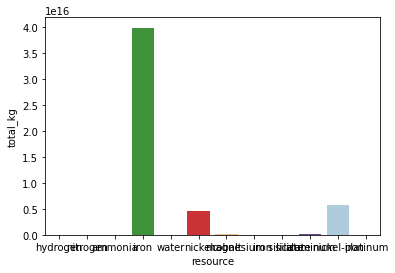

In [125]:
sns.barplot(x='resource', y='total_kg', palette=palette,data=total_resources)

In [123]:
sns.catplot(x='resource', y='total_kg', palette=palette, data=total_resources, height=5, aspect=3, kind='count', );
sns.despine()
plt.show()

ValueError: Either `x` or `y` must be None for kind='count'

In [127]:
df_acc.columns

Index(['Unnamed: 0', 'id', 'spkid', 'full_name', 'pdes', 'name', 'prefix',
       'neo', 'pha', 'H', 'G', 'M1', 'M2', 'K1', 'K2', 'PC', 'diameter',
       'extent', 'albedo', 'rot_per', 'GM', 'BV', 'UB', 'IR', 'spec_B',
       'spec_T', 'H_sigma', 'diameter_sigma', 'orbit_id', 'epoch', 'epoch_mjd',
       'epoch_cal', 'equinox', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n',
       'tp', 'tp_cal', 'per', 'per_y', 'moid', 'moid_ld', 'moid_jup', 't_jup',
       'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w',
       'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'class',
       'producer', 'data_arc', 'first_obs', 'last_obs', 'n_obs_used',
       'n_del_obs_used', 'n_dop_obs_used', 'condition_code', 'rms', 'two_body',
       'A1', 'A2', 'A3', 'DT', 'Object', 'Orbit ID', 'H (mag)',
       'Estimated Diameter (m)', 'OCC',
       'Min. delta-V [delta-V, dur.] (km/s), (d)',
       'Min. Duration [delta-V, dur.] (km/s), (d)', 'Viable Trajectories',
       'Next

In [128]:
df_acc[['diameter_clean', 'est_mass', 'Next Optical Opportunity (yyyy-mm [Vp])']].describe()

,diameter_clean
count,659.000000
mean,0.094003
std,0.120299
min,0.030000
25%,0.039500
50%,0.057500
75%,0.090500
max,1.398000


In [132]:
diameter = df_acc['diameter_clean']*1000
diameter.describe()

count     659.000000
mean       94.003035
std       120.299228
min        30.000000
25%        39.500000
50%        57.500000
75%        90.500000
max      1398.000000
Name: diameter_clean, dtype: float64

In [141]:
mass = df_acc['est_mass'] / 1e9
mass = mass.astype('float64')
mass.describe()

count       659.000000
mean       3320.546333
std       30464.901088
min           2.799908
25%          16.488388
50%          45.188878
75%         175.290101
max      646157.218548
Name: est_mass, dtype: float64

<AxesSubplot:xlabel='est_mass', ylabel='Count'>

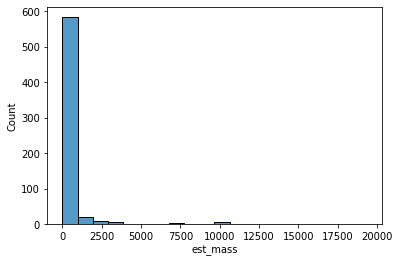

In [147]:
sns.histplot(mass[mass<20_000], bins=20)

In [148]:
col_analysis = ['id', 'name', 'diameter_clean', 'est_mass', 'Next Optical Opportunity (yyyy-mm [Vp])']

In [149]:
df_analysis = df_acc[col_analysis]

In [151]:
df_analysis['mass_mT'] = df_acc['est_mass'] / 1e9
df_analysis['mass_mT'] = df_analysis['mass_mT'].astype('float64')

<ipython-input-151-7c36dac17084>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['mass_mT'] = df_acc['est_mass'] / 1e9
<ipython-input-151-7c36dac17084>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['mass_mT'] = df_analysis['mass_mT'].astype('float64')


In [152]:
df_analysis[df_analysis['mass_mT']> 100000]

,id,name,diameter_clean,est_mass,Next Optical Opportunity (yyyy-mm [Vp]),mass_mT
1,a0025143,Itokawa,0.7720,108810416410242.265625,2021-06 [19.5],108810.416410
5,a0138404,NaN,0.7200,173283254450786.75,2021-05 [17.7],173283.254451
8,a0163899,NaN,1.3980,646157218547903.25,2021-10 [13.6],646157.218548
238,bK10P49Y,NaN,1.1415,351758199859084.25,? 2037-10 [19.6] ?,351758.199859
